# Model and Dataset Evaluation

This notebook demonstrates how to load and evaluate a model on a given dataset. It includes:

1. Parameter configuration
2. Data loading (both the dataset and any relevant AnnData objects)
3. Generating embeddings via a model
4. Visualizing embeddings with UMAP
5. Pairwise embedding analysis (e.g., similarity)
6. Metrics computation (e.g., scibEvaluator)
7. Annotation and zero-shot classification

You can adapt the parameters at the top to switch between different models and datasets.

In [11]:
%load_ext autoreload
%autoreload 2

## 1. Imports and Configuration

In [ ]:
import anndata
import numpy as np
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from mmcontext.engine import OmicsQueryAnnotator
from mmcontext.eval import evaluate_annotation_accuracy, scibEvaluator, zero_shot_classification_roc
from mmcontext.eval.utils import create_emb_pair_dataframe
from mmcontext.pl import plot_umap, visualize_embedding_clusters
from mmcontext.pl.plotting import plot_embedding_similarity, plot_query_scores_umap
from mmcontext.pp.utils import consolidate_low_frequency_categories

# mmcontext imports
from mmcontext.utils import load_test_adata_from_hf_dataset, setup_logging

logger = setup_logging()


############################################
#           CONFIGURABLE PARAMETERS       #
############################################

SAVE_RESULTS = False  # Optionally toggle saving results
SAVE_FIGURES = False  # Optionally toggle saving figures

MODEL_NAME = "jo-mengr/mmcontext-3_5k-cell_type-geneformer-2048"  # Example model name
DATASET_NAME = "cellxgene_pseudo_bulk_3_5k_pairs_cell_type"  # Example dataset name

# These keys can be adapted to your AnnData
BATCH_KEY = "dataset_title"
LABEL_KEY = "cell_type"  # The column used for bio labels
# Additional keys for scibEvaluator
EMBEDDING_KEYS = [
    "mmcontext_emb",
    "mmcontext_text_emb",
    "text_emb_original",
    "X_geneformer",
    "X_hvg",
    "X_pca",
    "X_scvi",
]

# Zero-shot classification function parameters
ZERO_SHOT_LABEL_KEY = LABEL_KEY
ZERO_SHOT_EMB_KEY = "mmcontext_emb"
ZERO_SHOT_TEXT_TEMPLATE = {}  # "A sample of {} from a healthy individual"

logger.info("Configuration parameters set.")

/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/trimap/__init__.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
2025-03-03 14:41:39,401 - root - INFO - Configuration parameters set.


## 2. Data Loading

In [3]:
logger.info("Loading dataset from HuggingFace...")
dataset = load_dataset(f"jo-mengr/{DATASET_NAME}", download_mode="force_redownload")

logger.info("Splitting to test subset...")
test_dataset = dataset["train"]

logger.info("Loading model...")
model = SentenceTransformer(MODEL_NAME)

logger.info("Loading AnnData from dataset...")
adata = load_test_adata_from_hf_dataset(test_dataset)

logger.info("Ensuring batch_key is categorical...")
adata.obs[BATCH_KEY] = adata.obs[BATCH_KEY].astype("category")

logger.info("Data loading complete.")
adata

2025-03-03 14:41:41,591 - root - INFO - Loading dataset from HuggingFace...
Generating val split: 100%|██████████| 7000/7000 [00:00<00:00, 3470464.30 examples/s]
2025-03-03 14:41:45,825 - root - INFO - Splitting to test subset...
2025-03-03 14:41:45,825 - root - INFO - Loading model...
2025-03-03 14:41:45,835 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-03-03 14:41:45,836 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: jo-mengr/mmcontext-35k-cell_type-geneformer-2048
2025-03-03 14:41:46,984 - mmcontext.pp.MMContextProcessor - INFO - Initialized PrecomputedProcessor. Retrieval mode: numpy. Metadata from AnnData obsm_key: X_geneformer.
2025-03-03 14:41:47,495 - root - INFO - Loading AnnData from dataset...
2025-03-03 14:42:22,961 - mmcontext.utils - INFO - File is a valid .h5ad file.
2025-03-03 14:42:29,614 - root - INFO - Ensuring batch_key is categorical...
2025-03-03 14:42:29,615 - root - INFO - Data l

AnnData object with n_obs × n_vars = 31500 × 25700
    obs: 'age', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'cluster_name', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'is_primary_data', 'lobe', 'organism', 'organism_ontology_term_id', 'orig.ident', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'based_on_n_cells', 'abstract', 'dataset_title', 'Sort_id', 'celltype_annotation', 'is_maternal_contaminant', 'original_pub', 'predicted_doublets', 'sample', 'sample_long', 'scvi_clusters', 'Age', 'Amyloid', 'Braak', 'Cell.Types', 'PMI', 'RIN', 'SORT', 'Sample.ID', 'dissection', 'roi', 'sample_id', 'supercluster_term', 'batch', 'cell_cycle', 'cell_description', 'BMI', 'cds', 'donor_region', 'group', 'hash_cluster', 'hash_label', 'hashed', 'lineage', 'pct_counts_hb', 'phase', 'treatment', 'type', 

In [4]:
# If the dataset has "pairs" in the same, filter the label column for == 1.0
if "pairs" in DATASET_NAME:
    test_dataset = test_dataset.filter(lambda x: x["label"] == 1.0)

Filter: 100%|██████████| 63000/63000 [00:00<00:00, 809686.39 examples/s]


In [5]:
import json

sample_ids = []
for row in test_dataset["anndata_ref"]:
    sample_ids.append(json.loads(row)["sample_id"])
adata_ids = adata.obs.index.values.tolist()
assert sample_ids == adata_ids, "Sample IDs do not match between HuggingFace and AnnData"

In [6]:
assert adata.obs[LABEL_KEY].values.tolist() == test_dataset["caption"]

## 3. Generate Embeddings

We generate:

- `mmcontext_emb` from the omics data
- `mmcontext_text_emb` from the text annotation

In [7]:
logger.info("Generating omics embeddings...")
omics_embeddings = model.encode(test_dataset["anndata_ref"])

2025-03-03 14:42:29,851 - root - INFO - Generating omics embeddings...
Batches: 100%|██████████| 985/985 [05:45<00:00,  2.85it/s]


In [8]:
logger.info("Generating text embeddings with pre-trained multi-modal model...")
text_annotations = adata.obs[LABEL_KEY].values.tolist()
text_embeddings = model.encode(text_annotations)
logger.info("Generating text embeddings with original text model...")
text_encoder_name = model[0].text_encoder_name
text_model = SentenceTransformer(text_encoder_name)
text_embeddings_original = text_model.encode(text_annotations)
logger.info("Embedding generation complete.")

2025-03-03 14:48:15,549 - root - INFO - Generating text embeddings with pre-trained multi-modal model...
Batches: 100%|██████████| 985/985 [00:12<00:00, 77.73it/s] 
2025-03-03 14:48:28,560 - root - INFO - Generating text embeddings with original text model...
2025-03-03 14:48:28,563 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-03-03 14:48:28,563 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: pritamdeka/S-BioBert-snli-multinli-stsb
Batches: 100%|██████████| 985/985 [00:11<00:00, 84.72it/s] 
2025-03-03 14:48:42,306 - root - INFO - Embedding generation complete.


In [9]:
logger.info("Storing embeddings in AnnData...")
adata.obsm["mmcontext_emb"] = omics_embeddings
adata.obsm["mmcontext_text_emb"] = text_embeddings
adata.obsm["text_emb_original"] = text_embeddings_original

2025-03-03 14:48:42,310 - root - INFO - Storing embeddings in AnnData...


In [172]:
# get index of cells that are from blood and 10x 3' v2
index_met = adata.obs["cell_type"] == "neuron"
# index_met = index_met & (adata.obs["assay"] == "10x 3' v2")
adata_neuron = adata[index_met].copy()

## 4. UMAP Visualization

Here, we visualize one of the embeddings (e.g., `mmcontext_text_emb`) with UMAP. We also remove low-frequency categories for better clarity in the plot.

In [190]:
# del adata.uns["cell_type_colors"]
# del adata.uns["tissue_colors"]
del adata_neuron.uns["dataset_title_colors"]

2025-03-03 14:48:42,314 - root - INFO - Consolidating low-frequency categories...
2025-03-03 14:48:43,914 - root - INFO - Plotting UMAP...
2025-03-03 14:48:43,914 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-03-03 14:48:43,915 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_text_emb'.


<Figure size 800x800 with 0 Axes>

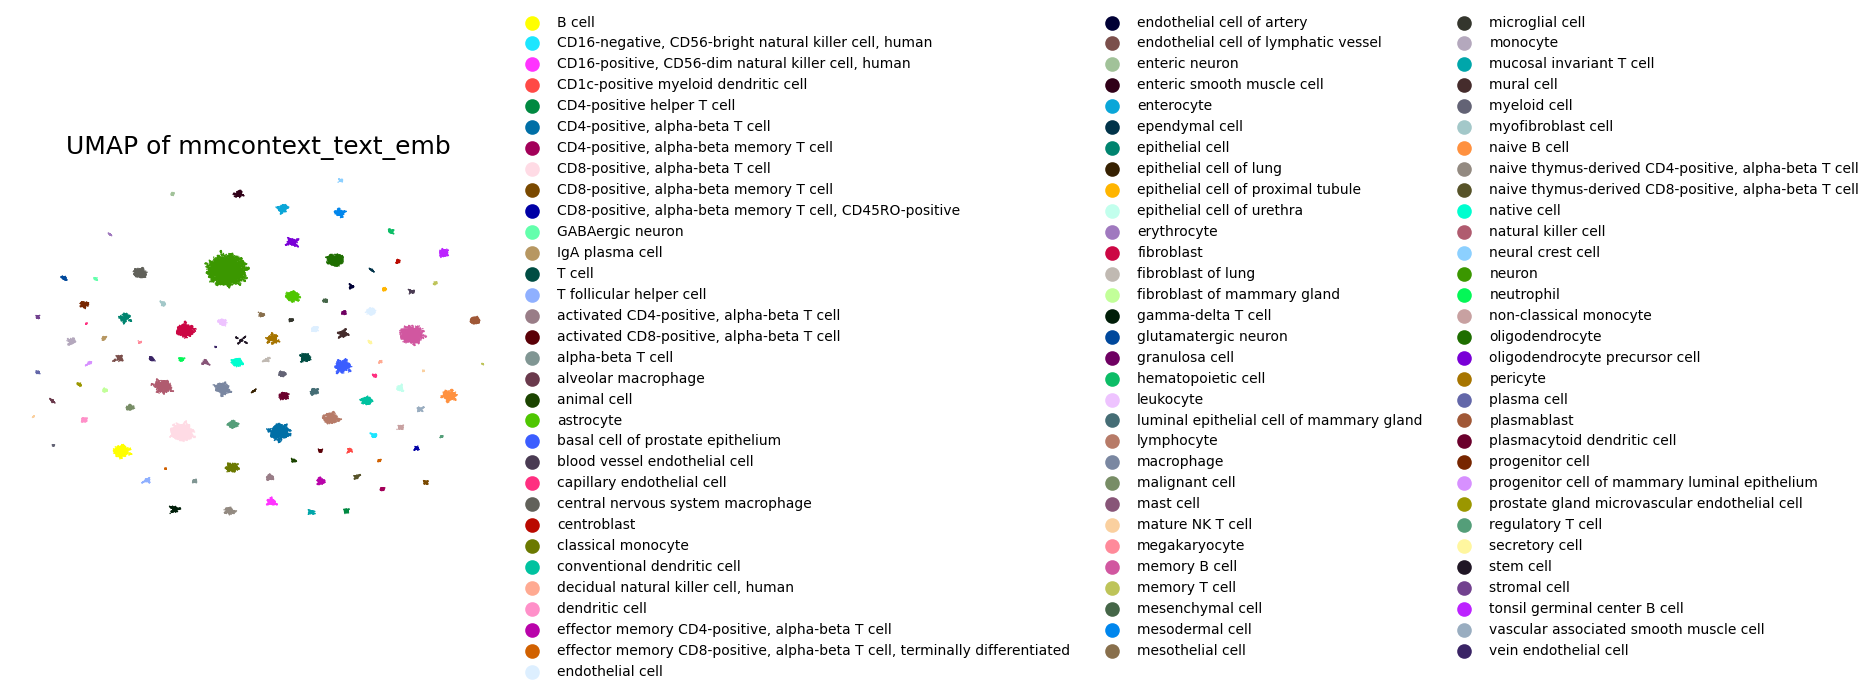

2025-03-03 14:49:18,160 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [10]:
logger.info("Consolidating low-frequency categories...")
LABEL_KEY = "cell_type"
adata_cut = adata.copy()
adata_cut = consolidate_low_frequency_categories(adata_cut, [LABEL_KEY], threshold=60, remove=True)

# The color_key can be changed to anything in adata.obs, e.g. BATCH_KEY or LABEL_KEY.
color_key = LABEL_KEY

logger.info("Plotting UMAP...")
plot_umap(adata_cut, color_key=color_key, embedding_key="mmcontext_text_emb")

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("umap_visualization.png", dpi=150)
    logger.info("UMAP plot saved to umap_visualization.png")

## 5. Pairwise Embedding Analysis

We use `create_emb_pair_dataframe` to create a paired DataFrame of two embeddings (omics vs text). Then:

- `visualize_embedding_clusters` to see how clusters form in a joint space.
- `plot_embedding_similarity` to examine similarity distributions for subsets.

2025-02-28 12:19:43,074 - root - INFO - Creating embedding pair dataframe...
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/utils.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  base_row[label_key] = adata.obs[label_key][sampled_indices[idx]]
2025-02-28 12:19:43,085 - mmcontext.eval.utils - INFO - Created a DataFrame with 400 rows (2 per pair).
2025-02-28 12:19:43,088 - root - INFO - Visualizing embedding clusters with UMAP...
2025-02-28 12:19:43,091 - mmcontext.pl.plotting - INFO - Applying UMAP to subset of size=80 with metric=cosine...
/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


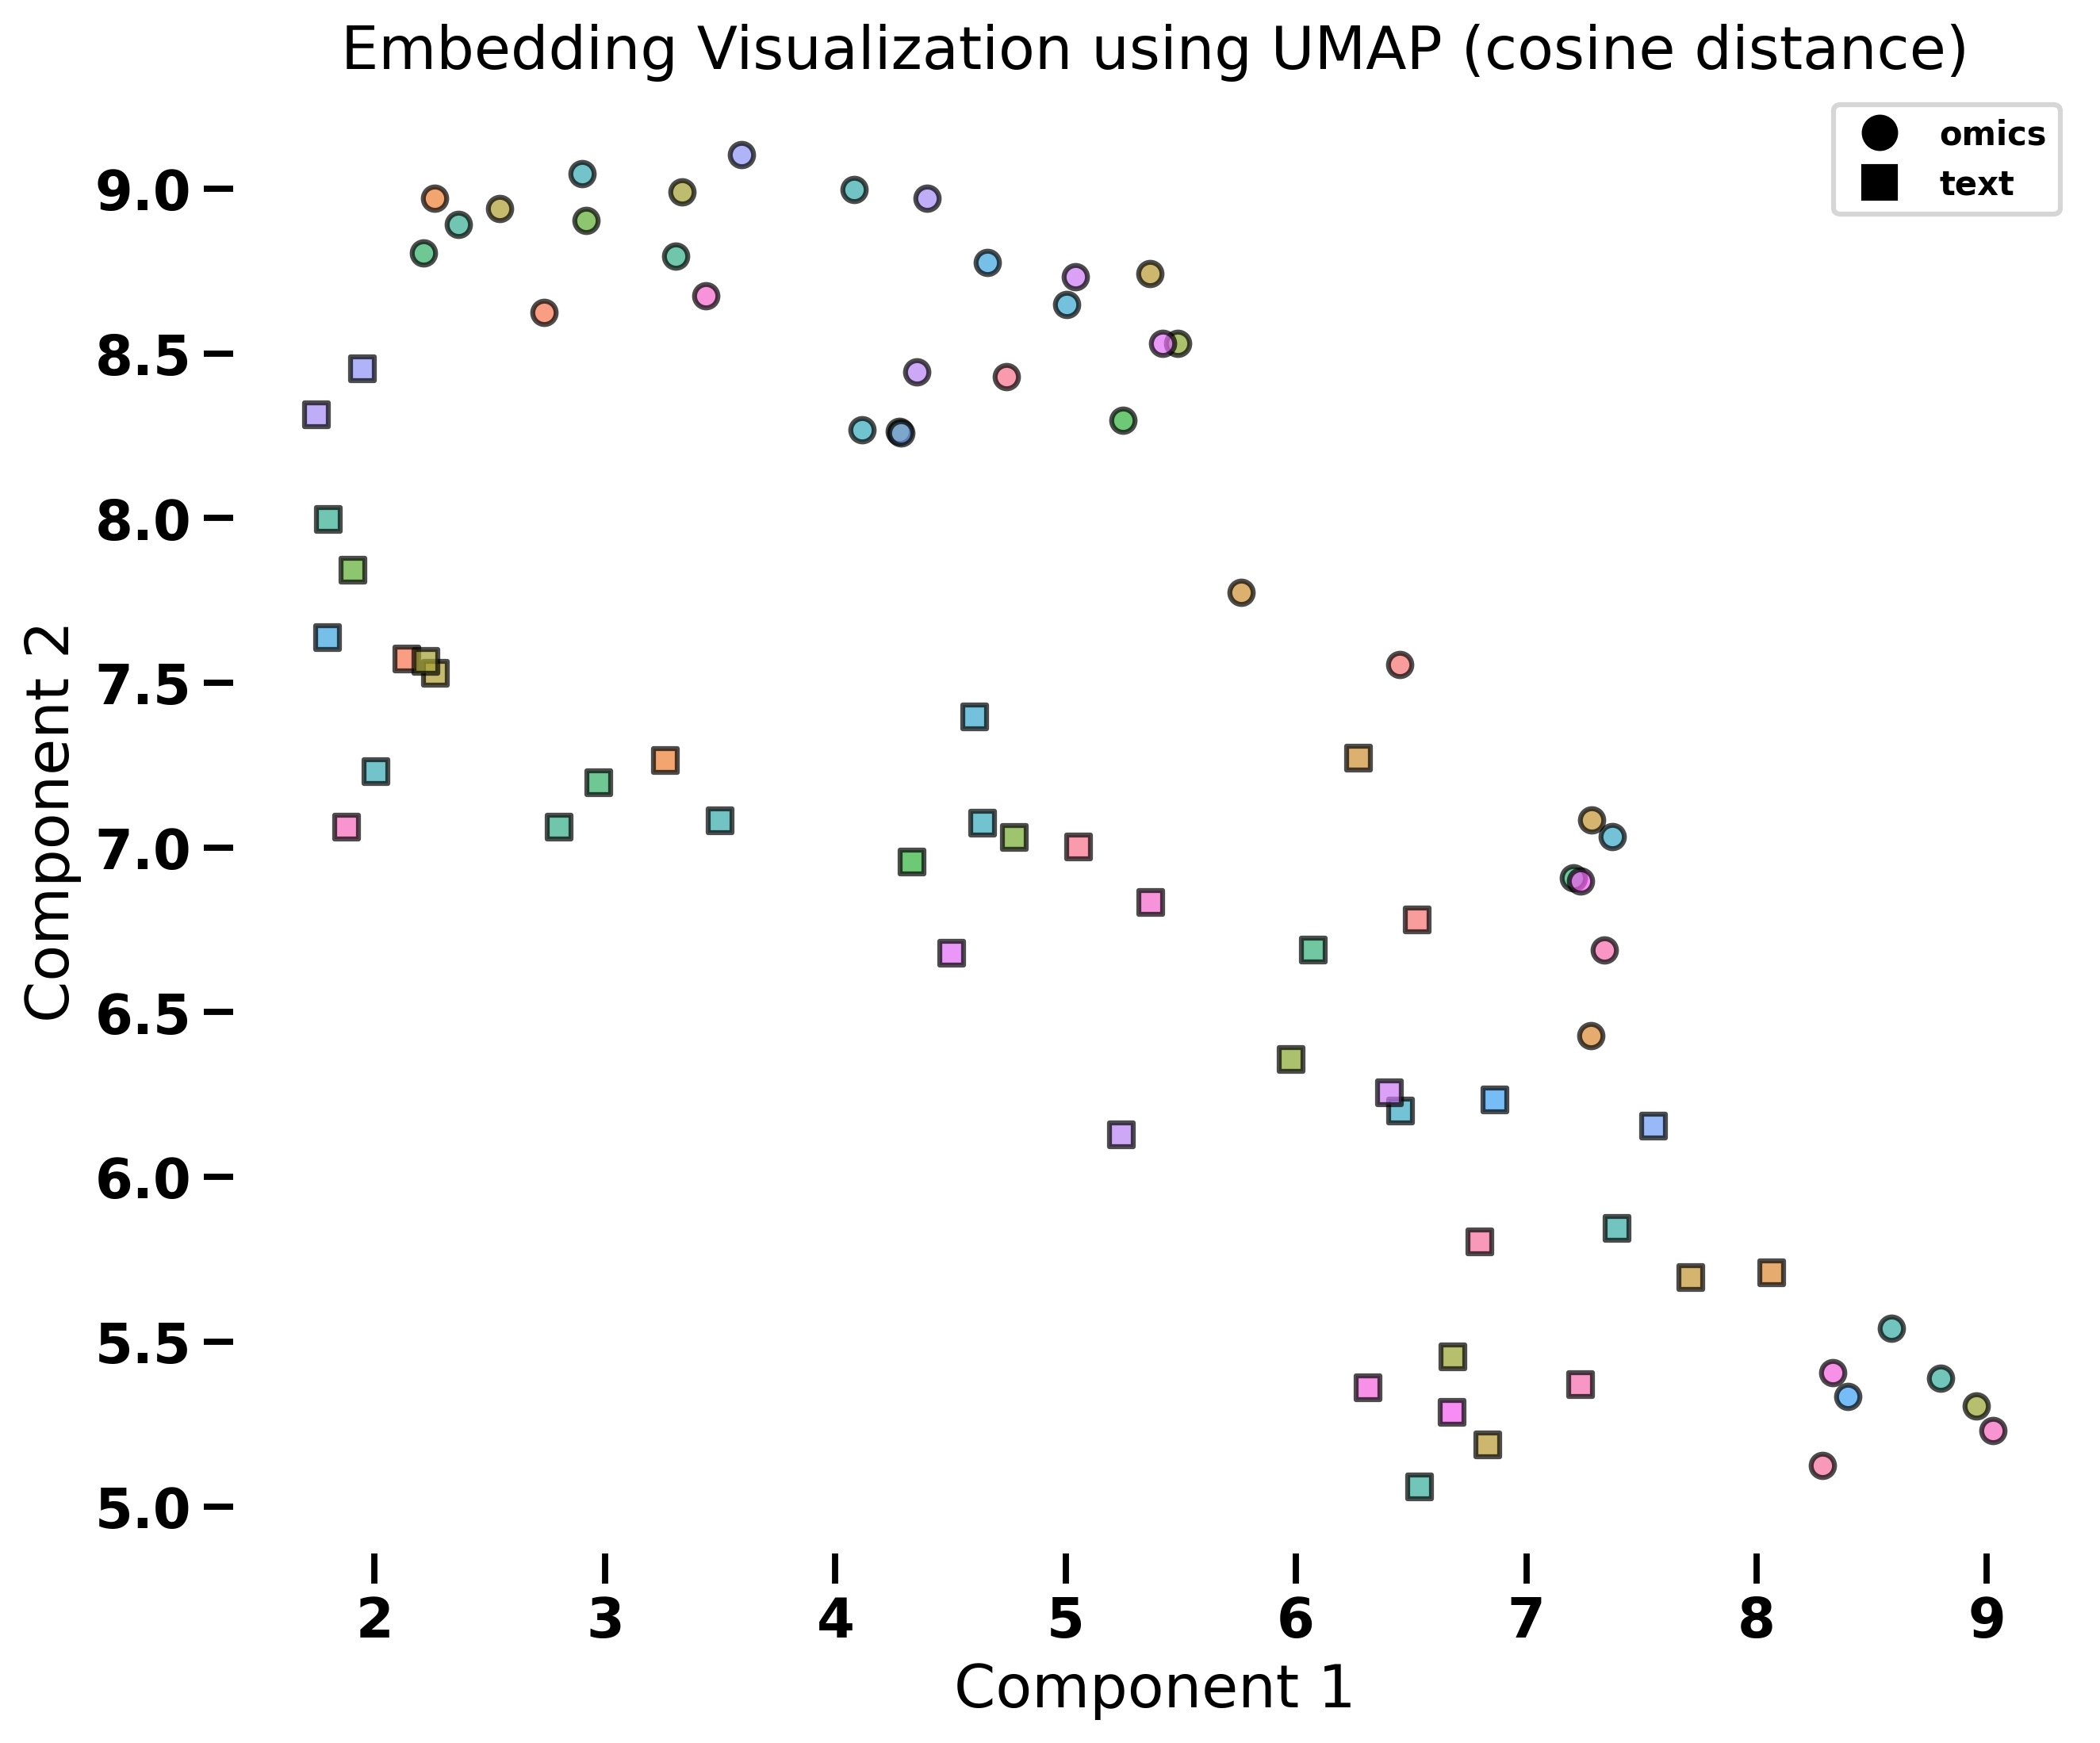

2025-02-28 12:19:43,351 - mmcontext.pl.plotting - INFO - Displayed embedding clusters interactively.


In [34]:
logger.info("Creating embedding pair dataframe...")
emb_pair_df = create_emb_pair_dataframe(
    adata,
    emb1_key="mmcontext_emb",
    emb2_key="mmcontext_text_emb",
    subset_size=200,
    label_keys=[BATCH_KEY, LABEL_KEY],
)

logger.info("Visualizing embedding clusters with UMAP...")
visualize_embedding_clusters(
    emb_pair_df, method="umap", metric="cosine", n_neighbors=15, min_dist=0.1, random_state=42, n_samples=40
)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("emb_clusters.png", dpi=150)
    logger.info("Embedding clusters plot saved to emb_clusters.png")

2025-02-28 12:19:43,376 - root - INFO - Plot embedding similarity with subset=10...


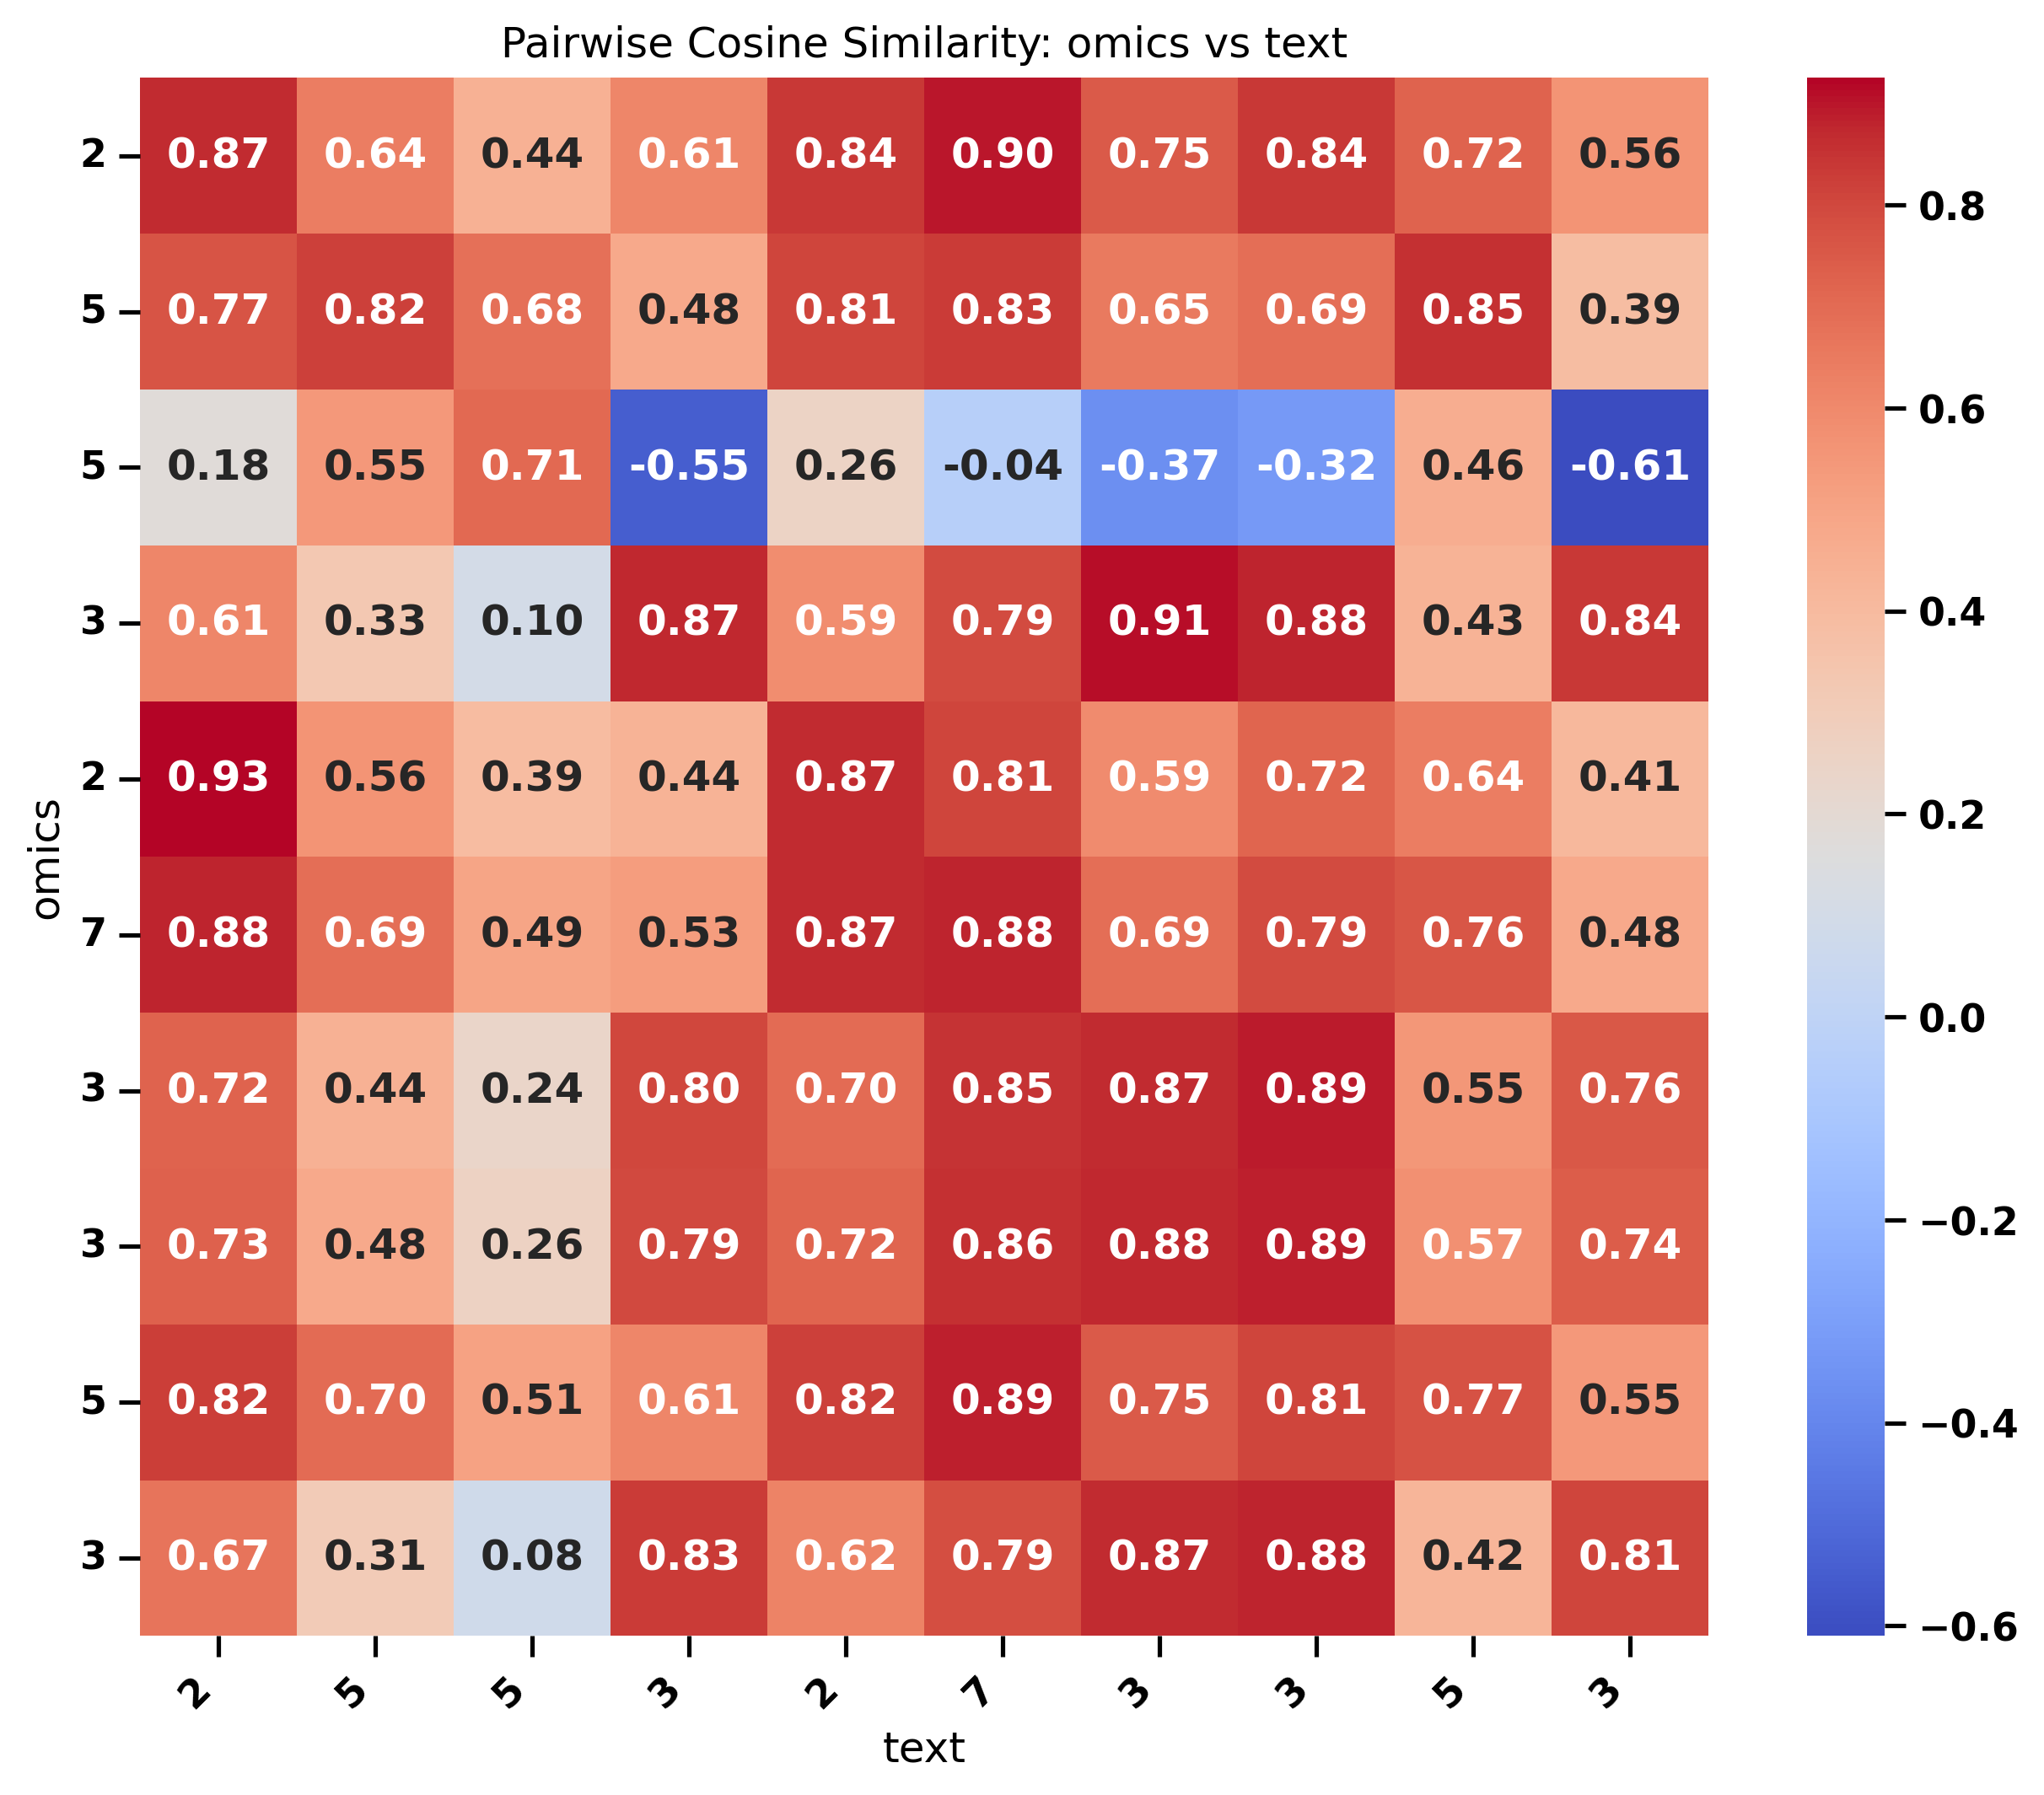

2025-02-28 12:19:43,513 - root - INFO - Plot embedding similarity with subset=10 using cell_type...


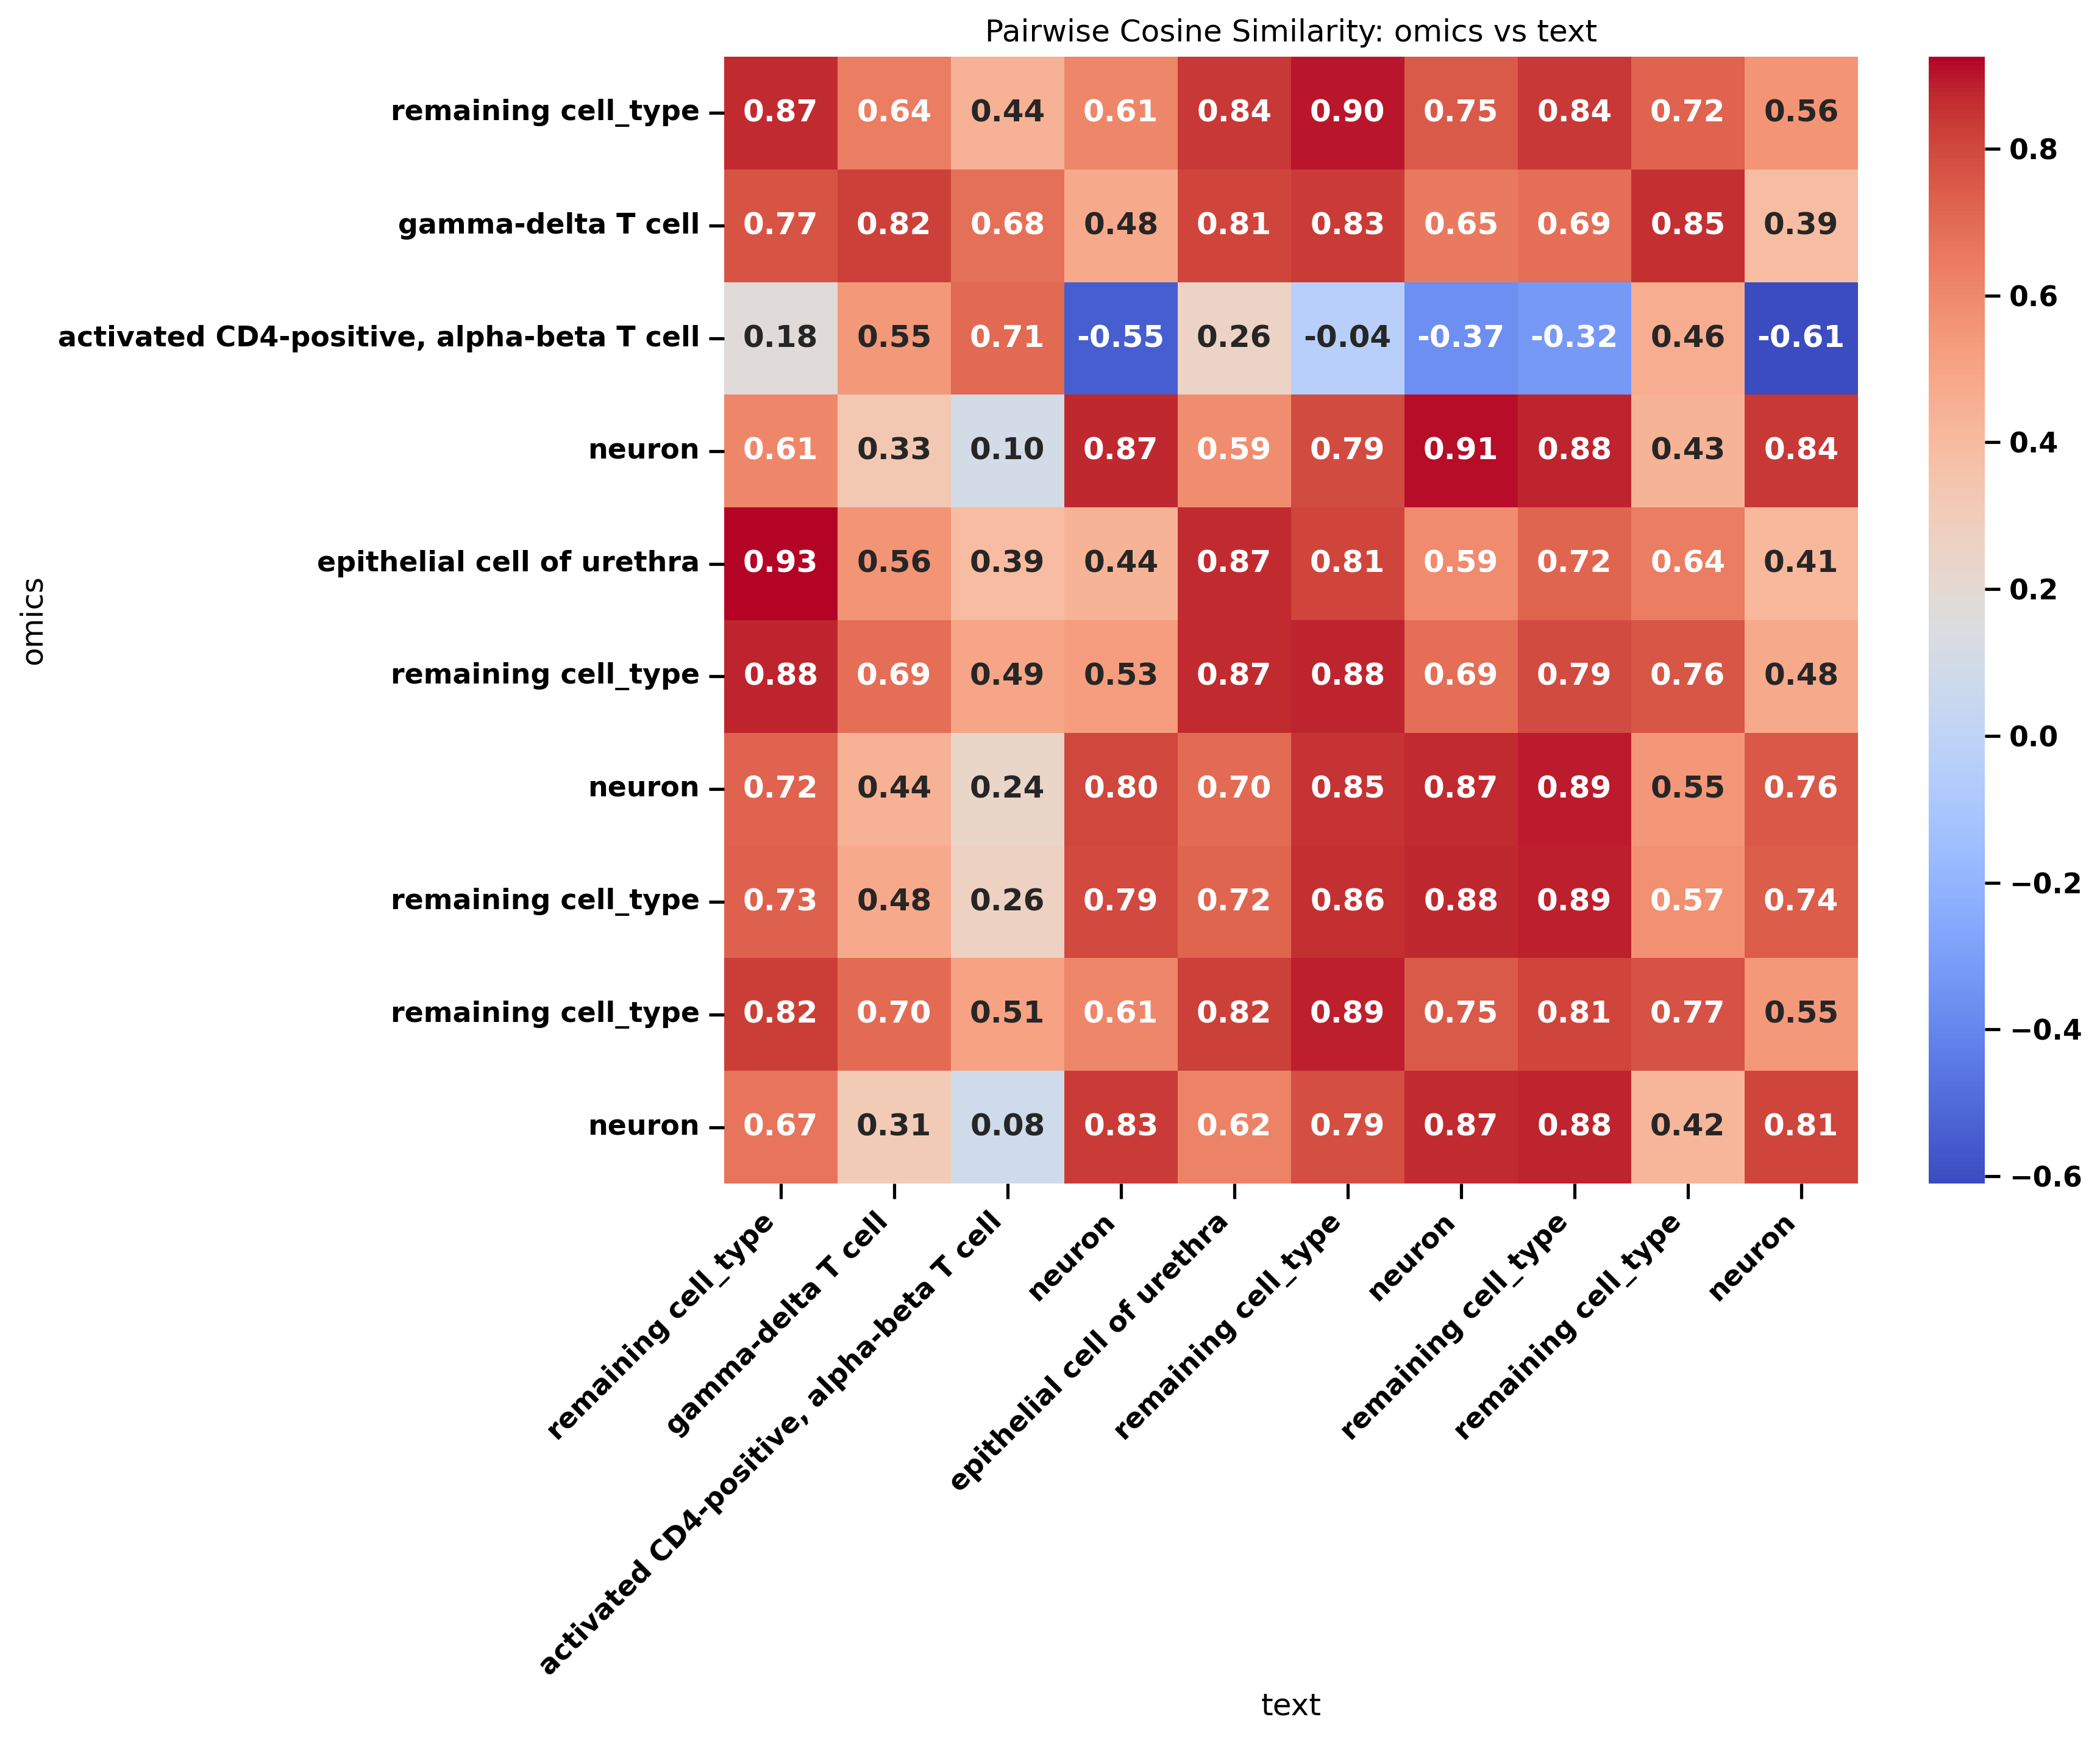

In [35]:
logger.info("Plot embedding similarity with subset=10...")
plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=10, label_key=BATCH_KEY)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("similarity_subset10_batch.png", dpi=150)
    logger.info("Similarity plot (subset=10, batch) saved.")

logger.info("Plot embedding similarity with subset=10 using cell_type...")
plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=10, label_key=LABEL_KEY)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("similarity_subset10_celltype.png", dpi=150)
    logger.info("Similarity plot (subset=10, cell_type) saved.")

If you want a larger subset for the similarity visualization (e.g., 200 samples):

2025-02-28 12:19:43,755 - root - INFO - Plot embedding similarity with subset=200...


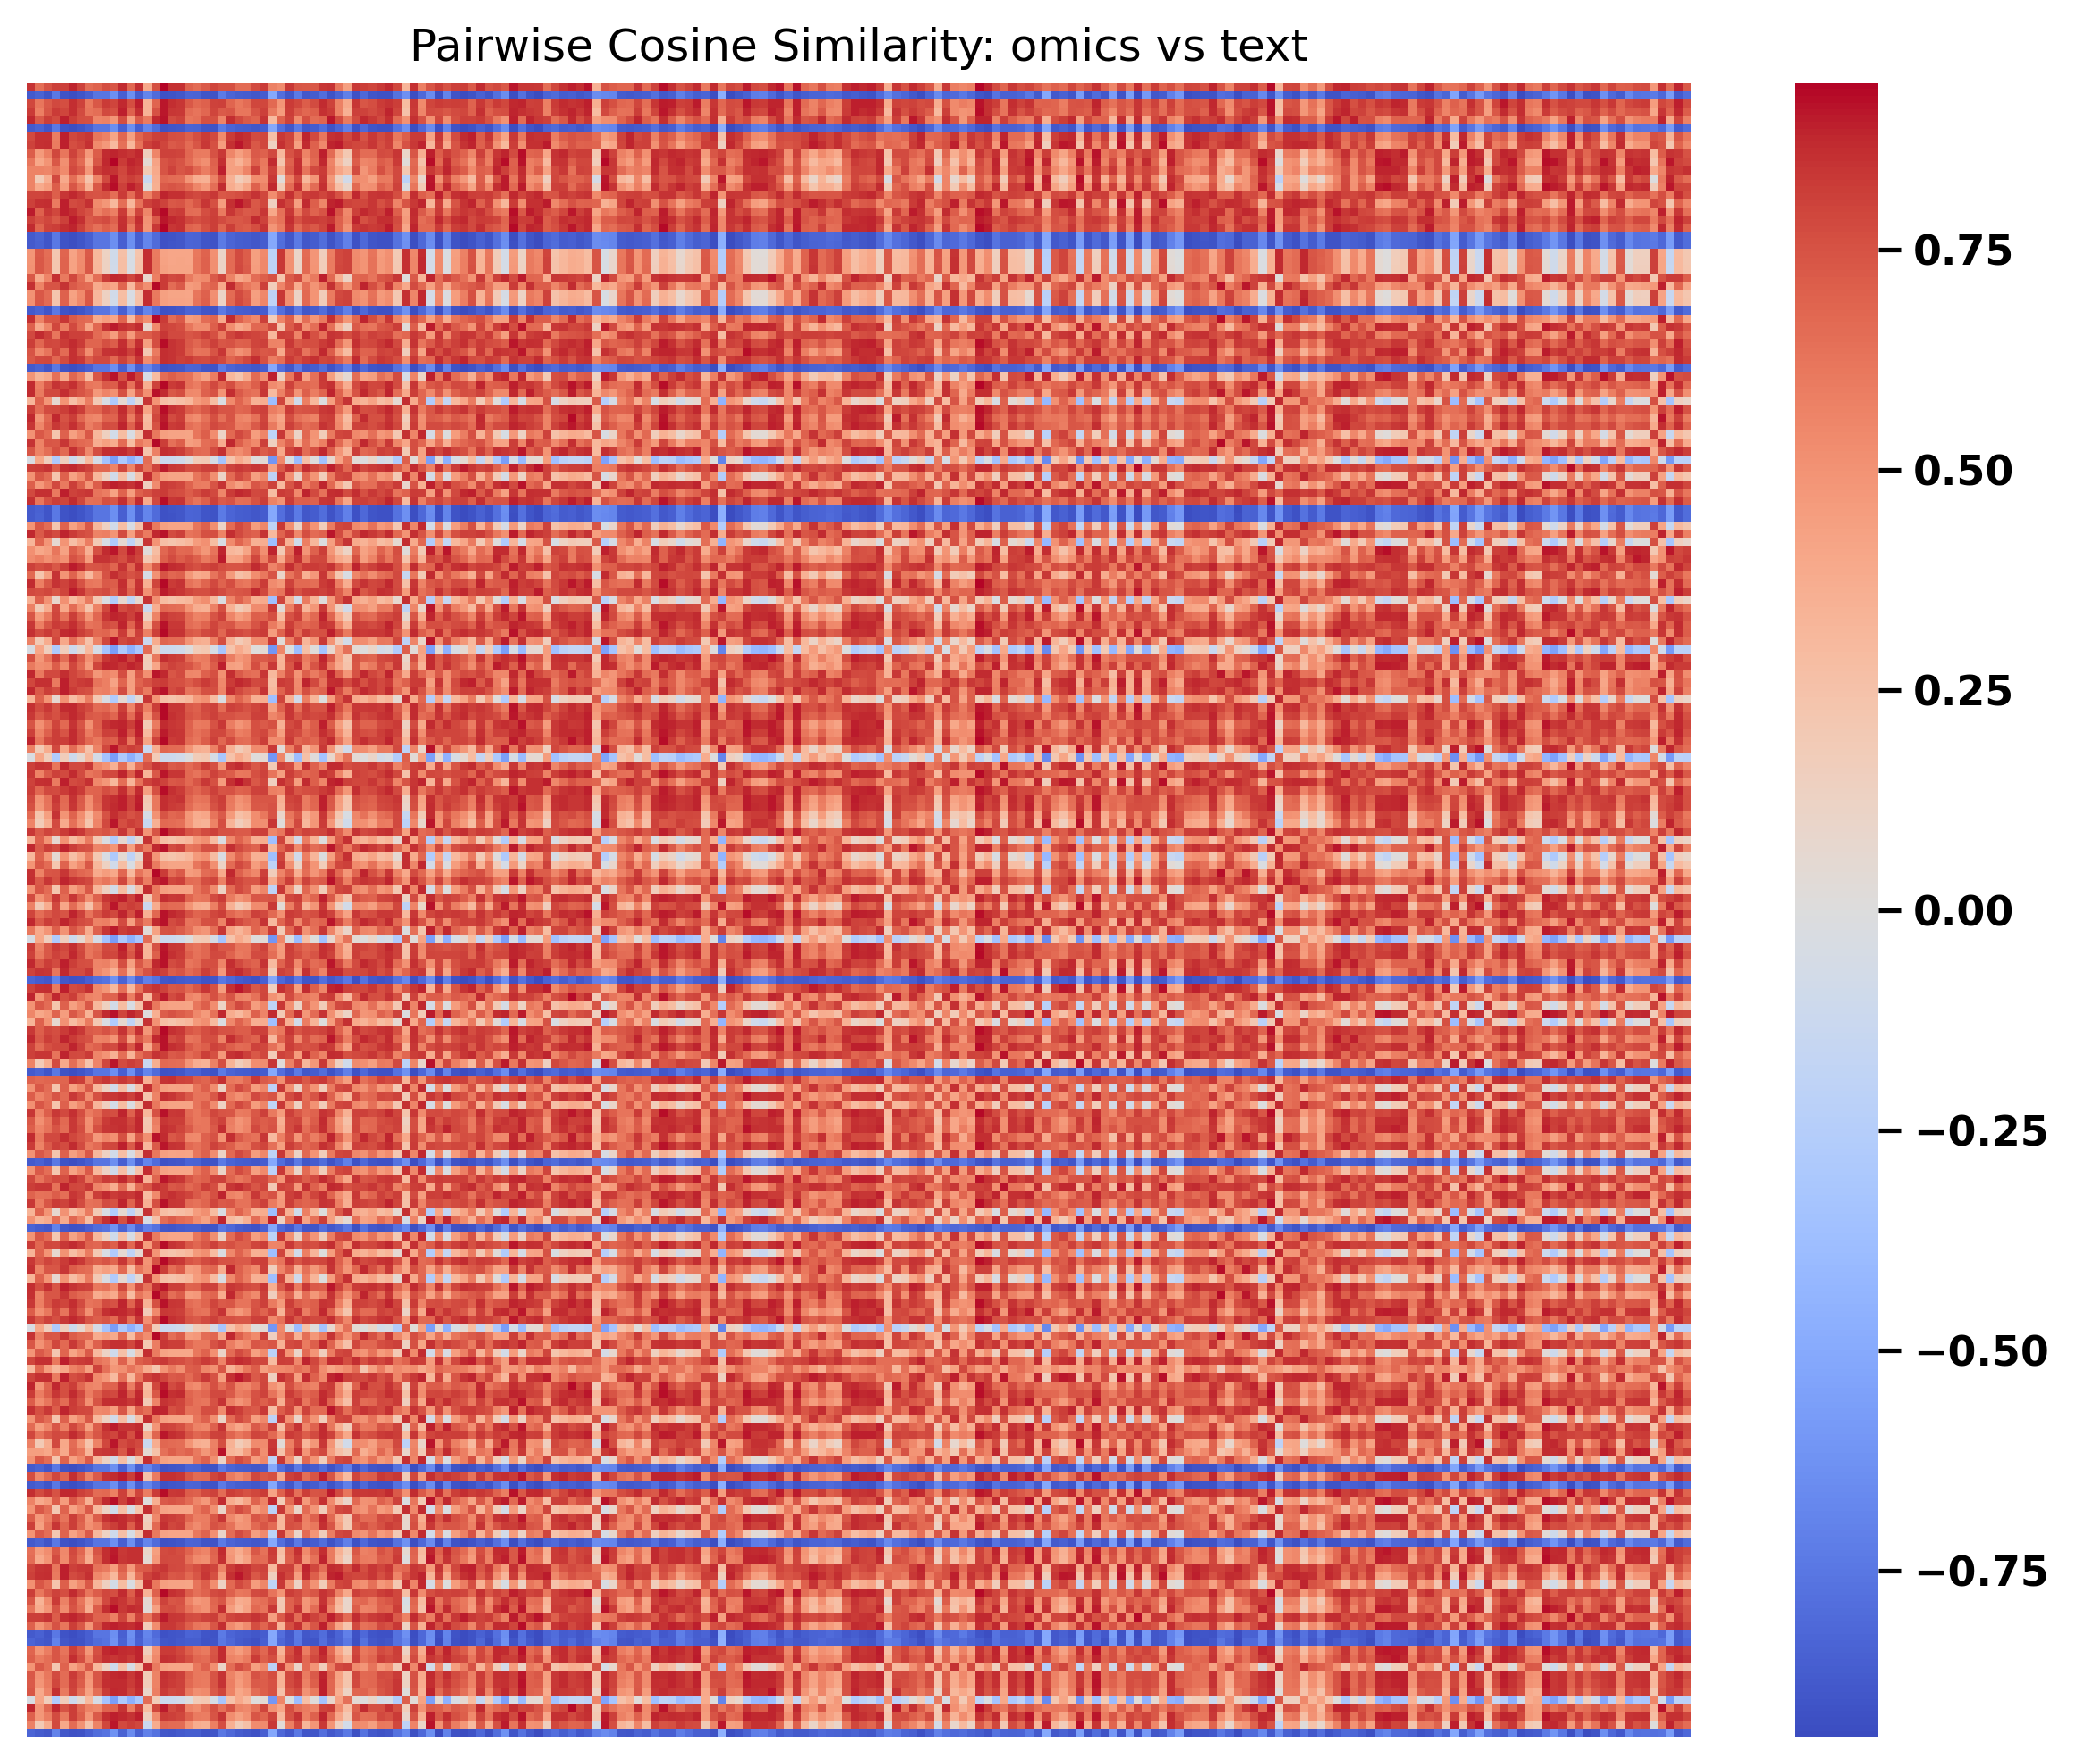

In [36]:
# Example: subset of 200
logger.info("Plot embedding similarity with subset=200...")
plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=200, label_key=LABEL_KEY)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("similarity_subset200_celltype.png", dpi=150)
    logger.info("Similarity plot (subset=200, cell_type) saved.")

## 6. scibEvaluator

We can use scibEvaluator for evaluating batch integration and bio-conservation metrics (Luecken et al.).

In [11]:
EMBEDDING_KEYS

['mmcontext_emb',
 'mmcontext_text_emb',
 'X_geneformer',
 'X_hvg',
 'X_pca',
 'X_scvi']

In [13]:
# from mmcontext.pp.utils import remove_zero_variance_cells, remove_zero_variance_genes
# adata = remove_zero_variance_genes(adata)
# adata = remove_zero_variance_cells(adata)

In [ ]:
logger.info("Initializing scibEvaluator...")
evaluator = scibEvaluator(
    adata=adata,
    batch_key=BATCH_KEY,
    label_key=LABEL_KEY,
    embedding_key=EMBEDDING_KEYS,
    n_top_genes=5000,
    max_cells=5000,
)

logger.info("Running scibEvaluator...")
res = evaluator.evaluate()
res_df = pd.DataFrame(res)
res_df

2025-02-28 10:29:07,181 - root - INFO - Initializing scibEvaluator...
2025-02-28 10:29:07,182 - root - INFO - Running scibEvaluator...
2025-02-28 10:29:07,183 - mmcontext.eval.evaluate_scib - INFO - Computing metrics on raw data...
2025-02-28 10:29:07,253 - mmcontext.eval.evaluate_scib - INFO - Reducing data to 5000 top genes using HVG selection...


HVG


2025-02-28 10:29:07,540 - mmcontext.eval.evaluate_scib - ERROR - Error in data reduction: Bin edges must be unique: Index([               -inf, 0.18775949861595367, 0.18775949861595367,
       0.18775949861595367, 0.18775949861595367,  0.2828699089425646,
        0.2828699089425646, 0.28952917601482675, 0.28952917601482675,
       0.28952917601482675,  0.3470630289908585,  0.4345983157036796,
        0.4772886746307804,  0.5147714000355701,  0.5967494081341395,
        0.6860152684203034,  0.9087340935720403,  1.2242478173249978,
         2.017335313907635,   5.331589494836573,                 inf],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg
2025-02-28 10:29:07,541 - mmcontext.eval.evaluate_scib - ERROR - Using full data for metrics computation.


Cluster for cluster_0.2 with leiden
resolution: 0.2, nmi: 0.44144982242452613
Cluster for cluster_0.4 with leiden
resolution: 0.4, nmi: 0.45085004249276706
Cluster for cluster_0.6 with leiden
resolution: 0.6, nmi: 0.4525768032715347
Cluster for cluster_0.8 with leiden
resolution: 0.8, nmi: 0.454667571594546
Cluster for cluster_1.0 with leiden
resolution: 1.0, nmi: 0.4590006930768707
Cluster for cluster_1.2 with leiden
resolution: 1.2, nmi: 0.4591133462527761
Cluster for cluster_1.4 with leiden
resolution: 1.4, nmi: 0.46077808648515345
Cluster for cluster_1.6 with leiden
resolution: 1.6, nmi: 0.4599183276661931
Cluster for cluster_1.8 with leiden
resolution: 1.8, nmi: 0.4597385767803866
Cluster for cluster_2.0 with leiden
resolution: 2.0, nmi: 0.45482001346181
optimised clustering against cell_type
optimal cluster resolution: 1.4
optimal score: 0.46077808648515345
isolated labels: no more than 1 batches per label
isolated labels: ['CD16-positive, CD56-dim natural killer cell, human', 'C

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)


CD16-positive, CD56-dim natural killer cell, human: 0.3270391634083719
Cluster for iso_label_0.2 with leiden


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-28 10:29:10,592 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


resolution: 0.2, max_f1: 0.05286343612334802
Cluster for iso_label_0.4 with leiden
CD4-positive helper T cell: 0.3766702732869881
resolution: 0.4, max_f1: 0.07079646017699115
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.0712166172106825
Cluster for iso_label_0.8 with leiden
CD8-positive, alpha-beta memory T cell: 0.3531787724387937
resolution: 0.8, max_f1: 0.07725321888412018
Cluster for iso_label_1.0 with leiden
CD8-positive, alpha-beta memory T cell, CD45RO-positive: 0.5105888091888233
resolution: 1.0, max_f1: 0.0935672514619883
Cluster for iso_label_1.2 with leiden
GABAergic neuron: 0.5413593684618119
resolution: 1.2, max_f1: 0.07547169811320754
Cluster for iso_label_1.4 with leiden
T cell: 0.34240095666164927
resolution: 1.4, max_f1: 0.07547169811320754
Cluster for iso_label_1.6 with leiden
activated CD4-positive, alpha-beta T cell: 0.7937575629443239
resolution: 1.6, max_f1: 0.07547169811320754
Cluster for iso_label_1.8 with leiden
resolution: 1.8, max_f1: 0.07

/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1033: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[k] = df_sub[k].cat.remove_unused_categories()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-28 10:32:18,147 - mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'
2025-02-28 10:32:22,926 

mean silhouette per group:                                       silhouette_score
group                                                 
B cell                                        0.799906
CD4-positive, alpha-beta T cell               0.657264
CD8-positive, alpha-beta T cell               0.803534
alveolar macrophage                           0.609843
classical monocyte                            0.778928
conventional dendritic cell                   0.718732
dendritic cell                                0.728558
endothelial cell of lymphatic vessel          0.817629
macrophage                                    0.698366
malignant cell                                0.774555
mast cell                                     0.747083
myeloid cell                                  0.734048
natural killer cell                           0.693682
non-classical monocyte                        0.646382
pericyte                                      0.753929
plasmacytoid dendritic cell           

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)


resolution: 0.2, max_f1: 0.18181818181818182
Cluster for iso_label_0.4 with leiden


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-28 10:32:26,945 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


resolution: 0.4, max_f1: 0.18181818181818182
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.18181818181818182
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 0.18181818181818182
Cluster for iso_label_1.0 with leiden
resolution: 1.0, max_f1: 0.18181818181818182
Cluster for iso_label_1.2 with leiden
resolution: 1.2, max_f1: 0.18181818181818182
Cluster for iso_label_1.4 with leiden
resolution: 1.4, max_f1: 0.18181818181818182
Cluster for iso_label_1.6 with leiden
CD16-positive, CD56-dim natural killer cell, human: 0.08442479372024536
CD4-positive helper T cell: 0.13600972294807434
resolution: 1.6, max_f1: 0.18181818181818182
Cluster for iso_label_1.8 with leiden
CD8-positive, alpha-beta memory T cell: 0.09080463647842407
CD8-positive, alpha-beta memory T cell, CD45RO-positive: 0.4657829776406288
resolution: 1.8, max_f1: 0.18181818181818182
Cluster for iso_label_2.0 with leiden
GABAergic neuron: 0.4825092516839504
T cell: 0.2744257301092148
resolution: 2.0,

2025-02-28 10:35:07,103 - mmcontext.eval.evaluate_scib - ERROR - Error computing PCR: pcr_comparison() got multiple values for argument 'adata_pre'


optimised clustering against cell_type
optimal cluster resolution: 1.0
optimal score: 0.15384615384615383
vascular associated smooth muscle cell: 0.15384615384615383


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-28 10:35:07,867 - mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'
2025-02-28 10:35:12,480 - mmcontext.eval.evaluate_scib - INFO - Computing metrics on embedding 'mmcontext_text_emb'...


mean silhouette per group:                                       silhouette_score
group                                                 
B cell                                        0.561848
CD4-positive, alpha-beta T cell               0.272428
CD8-positive, alpha-beta T cell               0.393710
alveolar macrophage                           0.754407
classical monocyte                            0.744487
conventional dendritic cell                   0.670524
dendritic cell                                0.628043
endothelial cell of lymphatic vessel          0.622027
macrophage                                    0.664359
malignant cell                                0.399563
mast cell                                     0.780519
myeloid cell                                  0.709054
natural killer cell                           0.633479
non-classical monocyte                        0.630243
pericyte                                      0.466892
plasmacytoid dendritic cell           

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)


resolution: 0.2, max_f1: 0.10869565217391304
Cluster for iso_label_0.4 with leiden
resolution: 0.4, max_f1: 0.1075268817204301
Cluster for iso_label_0.6 with leiden


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-28 10:35:19,371 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


resolution: 0.6, max_f1: 0.09615384615384615
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 0.10869565217391304
Cluster for iso_label_1.0 with leiden
resolution: 1.0, max_f1: 0.1075268817204301
Cluster for iso_label_1.2 with leiden
resolution: 1.2, max_f1: 0.10869565217391304
Cluster for iso_label_1.4 with leiden
resolution: 1.4, max_f1: 0.09900990099009901
Cluster for iso_label_1.6 with leiden
resolution: 1.6, max_f1: 0.11764705882352941
Cluster for iso_label_1.8 with leiden
resolution: 1.8, max_f1: 0.10416666666666666
Cluster for iso_label_2.0 with leiden
resolution: 2.0, max_f1: 0.11235955056179775
optimised clustering against cell_type
optimal cluster resolution: 1.6
optimal score: 0.11764705882352941
CD16-positive, CD56-dim natural killer cell, human: 0.11764705882352941
Cluster for iso_label_0.2 with leiden
CD16-positive, CD56-dim natural killer cell, human: 0.41083215177059174
resolution: 0.2, max_f1: 0.03636363636363636
Cluster for iso_label_0.4 with leiden
reso

2025-02-28 10:39:35,808 - mmcontext.eval.evaluate_scib - ERROR - Error computing PCR: pcr_comparison() got multiple values for argument 'adata_pre'


optimised clustering against cell_type
optimal cluster resolution: 1.0
optimal score: 0.1
vascular associated smooth muscle cell: 0.1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-28 10:39:36,773 - mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'
2025-02-28 10:39:41,066 - mmcontext.eval.evaluate_scib - INFO - Computing metrics on embedding 'text_emb_original'...


mean silhouette per group:                                       silhouette_score
group                                                 
B cell                                        0.765301
CD4-positive, alpha-beta T cell               0.683468
CD8-positive, alpha-beta T cell               0.827877
alveolar macrophage                           0.887323
classical monocyte                            0.840040
conventional dendritic cell                   0.806160
dendritic cell                                0.682481
endothelial cell of lymphatic vessel          0.886525
macrophage                                    0.893729
malignant cell                                0.877594
mast cell                                     0.908631
myeloid cell                                  0.885744
natural killer cell                           0.848192
non-classical monocyte                        0.767804
pericyte                                      0.861591
plasmacytoid dendritic cell           

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)


resolution: 0.2, max_f1: 0.12121212121212122
Cluster for iso_label_0.4 with leiden
resolution: 0.4, max_f1: 0.12121212121212122
Cluster for iso_label_0.6 with leiden


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-28 10:39:45,996 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


resolution: 0.6, max_f1: 0.12121212121212122
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 0.12121212121212122
Cluster for iso_label_1.0 with leiden
resolution: 1.0, max_f1: 0.12121212121212122
Cluster for iso_label_1.2 with leiden
resolution: 1.2, max_f1: 0.12121212121212122
Cluster for iso_label_1.4 with leiden
CD16-positive, CD56-dim natural killer cell, human: 0.49997090051510895
resolution: 1.4, max_f1: 0.12121212121212122
Cluster for iso_label_1.6 with leiden
CD4-positive helper T cell: 0.48961710929870605
resolution: 1.6, max_f1: 0.12121212121212122
Cluster for iso_label_1.8 with leiden
CD8-positive, alpha-beta memory T cell: 0.4112822189927101
resolution: 1.8, max_f1: 0.12121212121212122
Cluster for iso_label_2.0 with leiden
CD8-positive, alpha-beta memory T cell, CD45RO-positive: 0.5313663110136986
resolution: 2.0, max_f1: 0.12121212121212122
optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.12121212121212122
CD16-positive

2025-02-28 10:42:40,573 - mmcontext.eval.evaluate_scib - ERROR - Error computing PCR: pcr_comparison() got multiple values for argument 'adata_pre'


optimised clustering against cell_type
optimal cluster resolution: 0.4
optimal score: 0.11764705882352941
vascular associated smooth muscle cell: 0.11764705882352941


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-28 10:42:41,435 - mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'
2025-02-28 10:42:45,911 - mmcontext.eval.evaluate_scib - INFO - Computing metrics on embedding 'X_geneformer'...


mean silhouette per group:                                       silhouette_score
group                                                 
B cell                                        0.832662
CD4-positive, alpha-beta T cell               0.793692
CD8-positive, alpha-beta T cell               0.873802
alveolar macrophage                           0.901573
classical monocyte                            0.941290
conventional dendritic cell                   0.947688
dendritic cell                                0.893717
endothelial cell of lymphatic vessel          0.832120
macrophage                                    0.937426
malignant cell                                0.902881
mast cell                                     0.925438
myeloid cell                                  0.904043
natural killer cell                           0.937420
non-classical monocyte                        0.837577
pericyte                                      0.849336
plasmacytoid dendritic cell           

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)


resolution: 0.2, max_f1: 0.15
Cluster for iso_label_0.4 with leiden


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-28 10:42:50,946 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


resolution: 0.4, max_f1: 0.15
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.125
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 0.1256544502617801
Cluster for iso_label_1.0 with leiden
CD16-positive, CD56-dim natural killer cell, human: 0.4768318999558687
resolution: 1.0, max_f1: 0.14723926380368096
Cluster for iso_label_1.2 with leiden
CD4-positive helper T cell: 0.4117729365825653
resolution: 1.2, max_f1: 0.14723926380368096
Cluster for iso_label_1.4 with leiden
CD8-positive, alpha-beta memory T cell: 0.45440084859728813
resolution: 1.4, max_f1: 0.14723926380368096
Cluster for iso_label_1.6 with leiden
CD8-positive, alpha-beta memory T cell, CD45RO-positive: 0.5597568638622761
resolution: 1.6, max_f1: 0.14723926380368096
Cluster for iso_label_1.8 with leiden
GABAergic neuron: 0.48906014300882816
resolution: 1.8, max_f1: 0.14723926380368096
Cluster for iso_label_2.0 with leiden
T cell: 0.42043426632881165
resolution: 2.0, max_f1: 0.14634146341463414
o

2025-02-28 10:46:12,892 - mmcontext.eval.evaluate_scib - ERROR - Error computing PCR: pcr_comparison() got multiple values for argument 'adata_pre'


optimised clustering against cell_type
optimal cluster resolution: 1.4
optimal score: 0.3103448275862069
vascular associated smooth muscle cell: 0.3103448275862069


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-28 10:46:13,713 - mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'
2025-02-28 10:46:18,213 - mmcontext.eval.evaluate_scib - INFO - Computing metrics on embedding 'X_hvg'...


mean silhouette per group:                                       silhouette_score
group                                                 
B cell                                        0.888564
CD4-positive, alpha-beta T cell               0.747111
CD8-positive, alpha-beta T cell               0.827155
alveolar macrophage                           0.738385
classical monocyte                            0.858862
conventional dendritic cell                   0.871927
dendritic cell                                0.911456
endothelial cell of lymphatic vessel          0.748338
macrophage                                    0.770553
malignant cell                                0.812685
mast cell                                     0.754371
myeloid cell                                  0.774773
natural killer cell                           0.776162
non-classical monocyte                        0.717706
pericyte                                      0.869116
plasmacytoid dendritic cell           

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)


resolution: 0.2, max_f1: 0.02459016393442623
Cluster for iso_label_0.4 with leiden
resolution: 0.4, max_f1: 0.03239740820734341
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.1256544502617801
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 0.1145374449339207
Cluster for iso_label_1.0 with leiden
CD16-positive, CD56-dim natural killer cell, human: 0.4687595997012952
resolution: 1.0, max_f1: 0.10483870967741936
Cluster for iso_label_1.2 with leiden
CD4-positive helper T cell: 0.4630326827954242
resolution: 1.2, max_f1: 0.10788381742738588
Cluster for iso_label_1.4 with leiden
CD8-positive, alpha-beta memory T cell: 0.44674399731489317
resolution: 1.4, max_f1: 0.11206896551724138
Cluster for iso_label_1.6 with leiden
CD8-positive, alpha-beta memory T cell, CD45RO-positive: 0.4473292842256771


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-28 10:46:29,070 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


resolution: 1.6, max_f1: 0.11555555555555556
Cluster for iso_label_1.8 with leiden
GABAergic neuron: 0.43065969680528915
resolution: 1.8, max_f1: 0.11016949152542373
Cluster for iso_label_2.0 with leiden
resolution: 2.0, max_f1: 0.11063829787234043
optimised clustering against cell_type
optimal cluster resolution: 0.6
optimal score: 0.1256544502617801
T cell: 0.38619800043869545
CD16-positive, CD56-dim natural killer cell, human: 0.1256544502617801
Cluster for iso_label_0.2 with leiden
activated CD4-positive, alpha-beta T cell: 0.5631633060423187
resolution: 0.2, max_f1: 0.02295081967213115
Cluster for iso_label_0.4 with leiden
resolution: 0.4, max_f1: 0.030237580993520516
Cluster for iso_label_0.6 with leiden
alpha-beta T cell: 0.4412837848458706
resolution: 0.6, max_f1: 0.039603960396039604
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 0.04294478527607362
Cluster for iso_label_1.0 with leiden
astrocyte: 0.535053238535236
resolution: 1.0, max_f1: 0.046357615894039736


2025-02-28 10:50:03,465 - mmcontext.eval.evaluate_scib - ERROR - Error computing PCR: pcr_comparison() got multiple values for argument 'adata_pre'


optimised clustering against cell_type
optimal cluster resolution: 1.4
optimal score: 0.13559322033898305
vascular associated smooth muscle cell: 0.13559322033898305


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-28 10:50:06,735 - mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'
2025-02-28 10:50:09,264 - mmcontext.eval.evaluate_scib - INFO - Computing metrics on embedding 'X_pca'...


mean silhouette per group:                                       silhouette_score
group                                                 
B cell                                        0.623074
CD4-positive, alpha-beta T cell               0.395313
CD8-positive, alpha-beta T cell               0.606700
alveolar macrophage                           0.832817
classical monocyte                            0.647354
conventional dendritic cell                   0.841132
dendritic cell                                0.895689
endothelial cell of lymphatic vessel          0.900342
macrophage                                    0.872658
malignant cell                                0.841710
mast cell                                     0.936910
myeloid cell                                  0.927529
natural killer cell                           0.702681
non-classical monocyte                        0.700200
pericyte                                      0.877487
plasmacytoid dendritic cell           

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)


resolution: 0.2, max_f1: 0.05286343612334802
Cluster for iso_label_0.4 with leiden
CD16-positive, CD56-dim natural killer cell, human: 0.3270391634083719

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-28 10:50:13,899 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'



resolution: 0.4, max_f1: 0.07079646017699115
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.0712166172106825
Cluster for iso_label_0.8 with leiden
CD4-positive helper T cell: 0.3766702732869881
resolution: 0.8, max_f1: 0.07725321888412018
Cluster for iso_label_1.0 with leiden
CD8-positive, alpha-beta memory T cell: 0.3531787724387937
resolution: 1.0, max_f1: 0.0935672514619883
Cluster for iso_label_1.2 with leiden
CD8-positive, alpha-beta memory T cell, CD45RO-positive: 0.5105888091888233
resolution: 1.2, max_f1: 0.07547169811320754
Cluster for iso_label_1.4 with leiden
resolution: 1.4, max_f1: 0.07547169811320754
Cluster for iso_label_1.6 with leiden
GABAergic neuron: 0.5413593684618119
resolution: 1.6, max_f1: 0.07547169811320754
Cluster for iso_label_1.8 with leiden
T cell: 0.34240095666164927
resolution: 1.8, max_f1: 0.07575757575757576
Cluster for iso_label_2.0 with leiden
activated CD4-positive, alpha-beta T cell: 0.7937575629443239
resolution: 2.0, max_f1: 0.0

## 7. Annotation and Query

We can annotate and query our omics data using `OmicsQueryAnnotator`.

2025-02-28 12:21:53,062 - root - INFO - Annotating omics data...
2025-02-28 12:21:53,134 - mmcontext.engine.query_annotate - INFO - Using matrix multiplication to compute label similarities.
Batches: 100%|██████████| 985/985 [00:10<00:00, 96.96it/s] 
2025-02-28 12:22:03,626 - mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
2025-02-28 12:22:03,627 - mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
2025-02-28 12:22:03,648 - mmcontext.utils - INFO - Performing matrix multiplication on device=cpu
2025-02-28 12:22:51,961 - root - INFO - Plotting annotated data...
2025-02-28 12:22:51,962 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-02-28 12:22:51,962 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.
... storing 'best_label' as categorical


<Figure size 800x800 with 0 Axes>

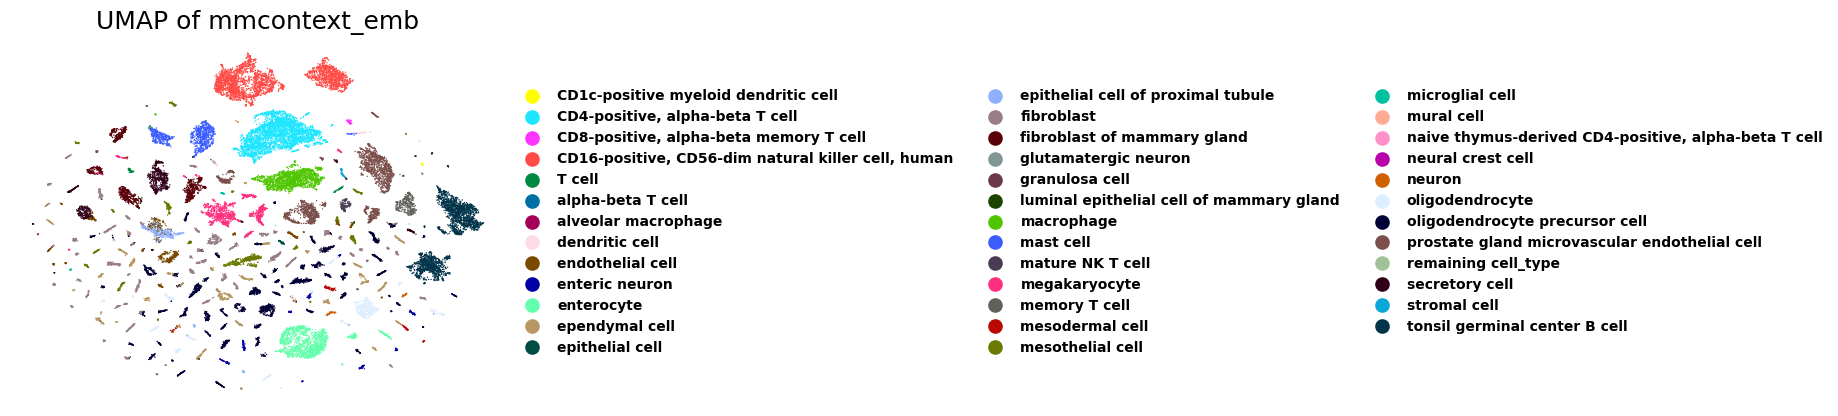

2025-02-28 12:23:07,845 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.
2025-02-28 12:23:07,845 - root - INFO - Evaluating annotation accuracy...
2025-02-28 12:23:07,846 - mmcontext.eval.annotation_accuracy - INFO - Evaluating annotation accuracy for keys 'cell_type' and 'best_label'. Accuracy = 7.52%
2025-02-28 12:23:07,847 - root - INFO - Accuracy of annotation: 0.07523809523809524


In [45]:
logger.info("Annotating omics data...")
annotator = OmicsQueryAnnotator(model)

# Suppose we have some labels to annotate, e.g. from an external source
labels = adata.obs[LABEL_KEY].values.tolist()
annotator.annotate_omics_data(adata, labels, text_template="{}")

logger.info("Plotting annotated data...")
plot_umap(adata, color_key="best_label", embedding_key="mmcontext_emb")

logger.info("Evaluating annotation accuracy...")
score = evaluate_annotation_accuracy(
    adata,
    true_key=LABEL_KEY,  # or whichever key is ground truth for your scenario
    inferred_key="best_label",
)
logger.info(f"Accuracy of annotation: {score}")

### Example: Query with text
You can query the dataset with text prompts and then visualize the result.

2025-02-28 12:23:53,807 - mmcontext.engine.query_annotate - INFO - Encoding the queries.
Batches: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
2025-02-28 12:23:54,127 - mmcontext.engine.query_annotate - INFO - Computing cosine similarity between queries and omics data.
2025-02-28 12:23:54,174 - mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
2025-02-28 12:23:54,175 - mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
2025-02-28 12:23:54,182 - mmcontext.utils - INFO - Performing matrix multiplication on device=cpu
2025-02-28 12:23:54,575 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-02-28 12:23:54,576 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.


<Figure size 800x800 with 0 Axes>

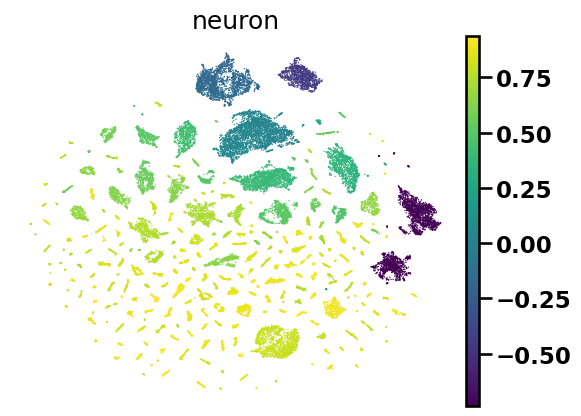

2025-02-28 12:24:09,801 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [46]:
# Example usage
qa = annotator  # if the OmicsQueryAnnotator has a method query_with_text
# logger.info("Querying dataset for 'This is a immune cell'...")
qa.query_with_text(adata, ["neuron"])

# Visualize
plot_query_scores_umap(adata, embedding_key="mmcontext_emb")
if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("query_scores_umap.png", dpi=150)
    logger.info("Query scores UMAP saved.")

## 8. Zero-Shot Classification ROC

Below is a function to compute a ROC-AUC for cell-type prediction (or any label) in a zero-shot manner.

In [48]:
logger.info("Computing zero-shot classification ROC...")
macro_auc, auc_details = zero_shot_classification_roc(
    adata,
    model,
    label_key=ZERO_SHOT_LABEL_KEY,
    emb_key=ZERO_SHOT_EMB_KEY,
    text_template="{}",
    device="cpu",
)
logger.info(f"Macro AUC: {macro_auc}")
logger.info(f"Detail per label: {auc_details}")

2025-02-28 12:24:40,040 - root - INFO - Computing zero-shot classification ROC...
2025-02-28 12:24:40,047 - mmcontext.eval.classification_roc - INFO - Building text queries for each label...
2025-02-28 12:24:40,048 - mmcontext.eval.classification_roc - INFO - Embedding 95 label queries...
Batches: 100%|██████████| 3/3 [00:00<00:00, 15.28it/s]
2025-02-28 12:24:40,247 - mmcontext.eval.classification_roc - INFO - Retrieving sample embeddings from adata.obsm[mmcontext_emb]...
2025-02-28 12:24:40,247 - mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
2025-02-28 12:24:40,248 - mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
2025-02-28 12:24:40,254 - mmcontext.utils - INFO - Performing matrix multiplication on device=cpu
2025-02-28 12:24:40,635 - mmcontext.eval.classification_roc - INFO - Zero-shot cell-type prediction macro-AUC: 0.8235
2025-02-28 12:24:40,636 - root - INFO - Macro AUC: 0.8234700390543733
2025-02-28 12:24:40,636 - root - INFO - Deta

In [49]:
logger.info("Computing zero-shot classification ROC...")
macro_auc, auc_details = zero_shot_classification_roc(
    adata,
    model,
    label_key="tissue",
    emb_key="mmcontext_emb",
    text_template="{}",
    device="cpu",
)
logger.info(f"Macro AUC: {macro_auc}")
logger.info(f"Detail per label: {auc_details}")

2025-02-28 12:25:10,105 - root - INFO - Computing zero-shot classification ROC...
2025-02-28 12:25:10,109 - mmcontext.eval.classification_roc - INFO - Building text queries for each label...
2025-02-28 12:25:10,109 - mmcontext.eval.classification_roc - INFO - Embedding 57 label queries...
Batches: 100%|██████████| 2/2 [00:00<00:00, 14.68it/s]
2025-02-28 12:25:10,249 - mmcontext.eval.classification_roc - INFO - Retrieving sample embeddings from adata.obsm[mmcontext_emb]...
2025-02-28 12:25:10,249 - mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
2025-02-28 12:25:10,249 - mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
2025-02-28 12:25:10,256 - mmcontext.utils - INFO - Performing matrix multiplication on device=cpu
2025-02-28 12:25:10,495 - mmcontext.eval.classification_roc - INFO - Zero-shot cell-type prediction macro-AUC: 0.6586
2025-02-28 12:25:10,496 - root - INFO - Macro AUC: 0.6586434522721459
2025-02-28 12:25:10,496 - root - INFO - Deta

## 9. (Optional) Saving Notebook Outputs

If you wish to programmatically save this notebook (e.g., for batch runs or CI/CD), you can use a dedicated library like `nbformat` or `papermill`. Here's a small snippet as an example (commented out by default).

In [ ]:
# Uncomment and adapt if you want to save the executed notebook programmatically
# import nbformat
# from nbformat.v4 import new_notebook
# from nbconvert.preprocessors import ExecutePreprocessor
# from nbconvert import HTMLExporter
#
# if SAVE_RESULTS:
#     logger.info("Saving notebook...")
#     with open("evaluation_notebook.ipynb", "r") as f:
#         nb = nbformat.read(f, as_version=4)
#     ep = ExecutePreprocessor(timeout=600)
#     ep.preprocess(nb, {'metadata': {'path': './'}})
#     with open("evaluation_notebook_executed.ipynb", "w") as f:
#         nbformat.write(nb, f)
#
#     # Optionally export to HTML
#     html_exporter = HTMLExporter()
#     body, _ = html_exporter.from_notebook_node(nb)
#     with open("evaluation_notebook_executed.html", "w") as f:
#         f.write(body)
#
#     logger.info("Notebook saved as evaluation_notebook_executed.ipynb and HTML version.")
